In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


LOAD AND PROCESS DATA

In [11]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv("Test.csv")
meta_df = pd.read_csv("Meta.csv")
train_df.head()


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [12]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [13]:
meta_df.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [14]:
#Explore Meta Info
id2label = dict(zip(meta_df.ClassId, meta_df.SignId))

LOAD AND PREPROCESSS IMAGES

In [16]:
def load_images(df, img_size=(32, 32)):
    images = []
    labels = []
    for _, row in df.iterrows():
        img = cv2.imread(row.Path)
        roi = img[row['Roi.Y1']:row['Roi.Y2'], row['Roi.X1']:row['Roi.X2']]
        roi = cv2.resize(roi, img_size)
        roi = roi / 255.0
        images.append(roi)
        labels.append(row.ClassId)
    return np.array(images), np.array(labels)

X_train, y_train = load_images(train_df)
X_test, y_test = load_images(test_df)

In [17]:
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

SLPIT TRAIN AND VALIDATION

In [18]:
X_train, X_val, y_train_categorical, y_val_categorical = train_test_split(X_train, y_train_categorical, test_size=0.2, random_state=42)

In [20]:
import warnings
warnings.filterwarnings("ignore")

BUILD THE CNN MODEL

In [21]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation='softmax')
])

COMPILING THE MODEL

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,459 (642.42 KB)

 Trainable params: 164,459 (642.42 KB)

 Non-trainable params: 0 (0.00 B)

TRAIN MODEL

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
EarlyStopping  = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train_categorical, 
                    validation_data=(X_val, y_val_categorical), 
                    epochs=20, 
                    callbacks=[EarlyStopping])

Epoch 1/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.3755 - loss: 2.3194 - val_accuracy: 0.9591 - val_loss: 0.1497
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9148 - loss: 0.2915 - val_accuracy: 0.9836 - val_loss: 0.0646
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9603 - loss: 0.1416 - val_accuracy: 0.9899 - val_loss: 0.0407
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9720 - loss: 0.0963 - val_accuracy: 0.9938 - val_loss: 0.0280
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9814 - loss: 0.0627 - val_accuracy: 0.9909 - val_loss: 0.0361
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9861 - loss: 0.0534 - val_accuracy: 0.9936 - val_loss: 0.0242
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9869 - loss: 0.0446 - val_accuracy: 0.9935 - val_loss: 0.0245
Epoch 8/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9877 - loss: 0.0421 - 

EVALAUTION OF MODEL

In [25]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9734 - loss: 0.1498
Test Loss: 0.1504717916250229, Test Accuracy: 0.9745843410491943


METRICS


In [26]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_categorical, axis=1)



395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


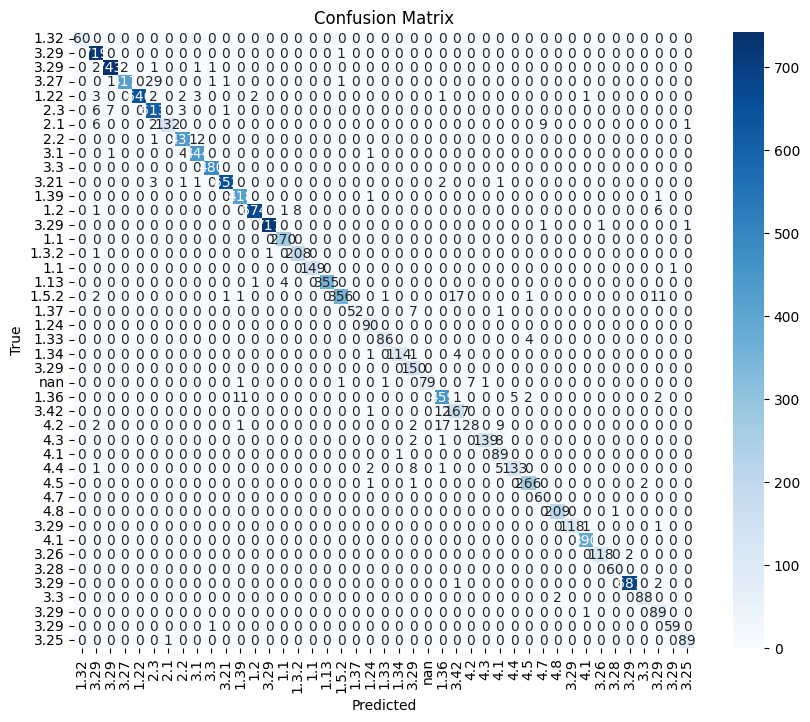

In [27]:
conf_matrix= confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=meta_df.SignId, yticklabels=meta_df.SignId)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [29]:
print("classification_report\n")
print(classification_report(y_true_labels, y_pred_labels))

classification_report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.97      1.00      0.98       720
           2       0.99      0.99      0.99       750
           3       1.00      0.93      0.96       450
           4       1.00      0.98      0.99       660
           5       0.94      0.97      0.96       630
           6       0.99      0.88      0.93       150
           7       0.98      0.97      0.97       450
           8       0.96      0.99      0.97       450
           9       0.99      1.00      1.00       480
          10       1.00      0.99      0.99       660
          11       0.97      1.00      0.98       420
          12       1.00      0.98      0.99       690
          13       1.00      1.00      1.00       720
          14       0.98      1.00      0.99       270
          15       0.96      0.99      0.98       210
          16       1.00      0.99      1.00       150
    

VISUALIZE SAMPLE PREDICTIONS

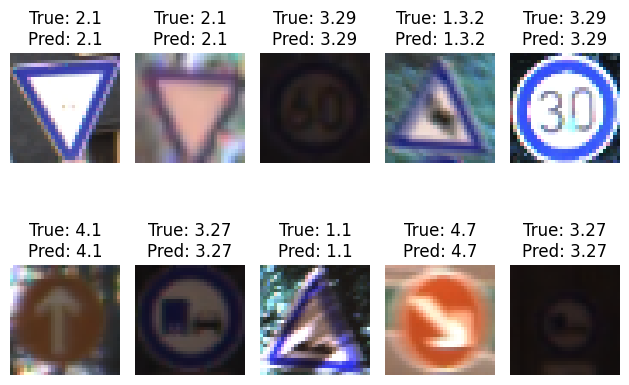

In [32]:
# Make safe dictionary
classes = {int(k): str(v) for k, v in zip(meta_df['ClassId'], meta_df['SignId'])}

# Show predictions
for i in range(10):
    idx = np.random.randint(0, len(X_test))
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx])
    true_label = int(y_true_labels[idx])
    pred_label = int(y_pred_labels[idx])
    plt.title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

SAVE MODEL

In [33]:
model.save("traffic_sign_model.h5")
